In [2]:
import gym, os
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Multinomial
import torchvision.transforms as T
from datetime import datetime
from stable_baselines import logger
from stable_baselines.bench import Monitor
from stable_baselines.common import set_global_seeds
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.vec_env import VecFrameStack

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 123
num_envs = 16
num_frames = 4

def custom_atari_env(env_id, num_env, seed, wrapper_kwargs=None, start_index=0,
                     allow_early_resets=True):
    if wrapper_kwargs is None:
        wrapper_kwargs = {}
    
    def make_env(rank):
        def _thunk():
            env = make_atari(env_id)
            env.seed(seed + rank)
            env = Monitor(env, logger.get_dir() and os.path.join(
                logger.get_dir(), str(rank)),
                          allow_early_resets=allow_early_resets)
            return wrap_deepmind(env, **wrapper_kwargs)
        
        return _thunk
    
    set_global_seeds(seed)
    return DummyVecEnv([make_env(i + start_index) for i in range(num_env)])


env = custom_atari_env('BreakoutNoFrameskip-v4', num_env=num_envs, seed=42)
env = make_atari_env('PongNoFrameskip-v0', num_env=num_envs, seed=42)
env = VecFrameStack(env, n_stack=num_frames)


Helper function

In [3]:

def process_rollout(gamma = 0.99, lambd = 1.0):
    _, _, _, _, last_values = steps[-1]
    returns = last_values.data

    advantages = torch.zeros(num_envs, 1)
    #if cuda: advantages = advantages.cuda()

    out = [None] * (len(steps) - 1)

    # run Generalized Advantage Estimation, calculate returns, advantages
    for t in reversed(range(len(steps) - 1)):
        rewards, masks, actions, policies, values = steps[t]
        _, _, _, _, next_values = steps[t + 1]

        returns = rewards + returns * gamma * masks

        deltas = rewards + next_values.data * gamma * masks - values.data
        advantages = advantages * gamma * lambd * masks + deltas

        out[t] = actions, policies, values, returns, advantages

    # return data as batched Tensors, Variables
    return map(lambda x: torch.cat(x, 0), zip(*out))

def ortho_weights(shape, scale=1.):
    """ PyTorch port of ortho_init from baselines.a2c.utils """
    shape = tuple(shape)

    if len(shape) == 2:
        flat_shape = shape[1], shape[0]
    elif len(shape) == 4:
        flat_shape = (np.prod(shape[1:]), shape[0])
    else:
        raise NotImplementedError

    a = np.random.normal(0., 1., flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.transpose().copy().reshape(shape)

    if len(shape) == 2:
        return torch.from_numpy((scale * q).astype(np.float32))
    if len(shape) == 4:
        return torch.from_numpy((scale * q[:, :shape[1], :shape[2]]).astype(np.float32))

def game_initializer(module):
    classname = module.__class__.__name__
    if classname == 'Linear':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'Conv2d':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'LSTM':
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'weight_hh' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'bias' in name:
                param.data.zero_()

Creating two seperate networks the actor and the critic

In [4]:

class ActorCritic(nn.Module):
    def __init__(self, num_actions):
        super().__init__()

        self.conv = nn.Sequential(nn.Conv2d(4, 32, 8, stride=4),
                                  nn.ReLU(),
                                  nn.Conv2d(32, 64, 4, stride=2),
                                  nn.ReLU(),
                                  nn.Conv2d(64, 64, 3, stride=1),
                                  nn.ReLU())
        
        
        self.fc = nn.Sequential(nn.Linear(64 * 7 * 7, 512),
                                nn.ReLU())

        self.a = nn.Linear(512, num_actions)
        self.c = nn.Linear(512, 1)

        self.num_actions = num_actions

        # parameter initialization
        self.apply(game_initializer)
        self.a.weight.data = ortho_weights(self.a.weight.size(), scale=.01)
        self.c.weight.data = ortho_weights(self.c.weight.size())

    def forward(self, conv_in):
        N = conv_in.size()[0]

        conv_out = self.conv(conv_in).view(N, 64 * 7 * 7)

        fc_out = self.fc(conv_out)

        a = self.a(fc_out)
        c = self.c(fc_out)

        return a, c

In [4]:
learn_rate = 1e-4
val_coeff = 0.5
ent_coeff = 0.01
rollout_steps = 50
max_steps = 5e7

# Get number of actions from gym action space
n_actions = env.action_space.n

actor_critic = ActorCritic(n_actions).to(device)

optimizer = optim.Adam(actor_critic.parameters(), lr=learn_rate)

scores_all_envs = []
total_steps_list = []
envs_list = []

steps = []
ep_rewards = [0.] * num_envs
total_steps = 0

state = env.reset()
while total_steps < max_steps:
    for _ in range(rollout_steps):
        state = torch.from_numpy(state.transpose((0, 3, 1, 2))).float() / 255.
        logit, values = actor_critic(state)
        
        probs = F.softmax(logit)
        actions = probs.multinomial(1).data
        
        state, rewards, dones, _ = env.step(actions.cpu().numpy())


        total_steps += num_envs
        for i, done in enumerate(dones):
                ep_rewards[i] += rewards[i]
                if done:
                    #print(dones)
                    scores_all_envs.append(ep_rewards[i])
                    total_steps_list.append(total_steps)
                    envs_list.append(i)
                    if i == 0:
                        print('Timestamp: {}, Steps: {}, Score env: {}, Env no.: {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), total_steps, ep_rewards[i], i+1))
                    ep_rewards[i] = 0
                    #print(ep_rewards)
        masks = (1. - torch.from_numpy(np.array(dones, dtype=np.float32))).unsqueeze(1)
        rewards = torch.from_numpy(rewards).float().unsqueeze(1)
        steps.append((rewards, masks, actions, logit, values))

    final_state = torch.from_numpy(state.transpose((0, 3, 1, 2))).float() / 255.
    _, final_values = actor_critic(final_state)
    steps.append((None, None, None, None, final_values))
    actions, logit, values, returns, advantages = process_rollout()
    
    probs = F.softmax(logit)
    log_probs = F.log_softmax(logit)
    log_action_probs = log_probs.gather(-1, actions)

    policy_loss = (-log_action_probs * advantages).sum()
    value_loss = (0.5*(values - returns) ** 2.).sum()
    entropy_loss = (log_probs * probs).sum()

    ac_loss = (policy_loss + value_loss * val_coeff + entropy_loss * ent_coeff)

    ac_loss.backward()
    nn.utils.clip_grad_norm(actor_critic.parameters(), 50.)
    optimizer.step()
    optimizer.zero_grad()
    steps = []
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Timestamp: 2019-05-25 22:34:05, Steps: 14528, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 22:34:28, Steps: 27376, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 22:34:54, Steps: 42560, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 22:35:15, Steps: 54640, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 22:35:41, Steps: 69952, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 22:36:08, Steps: 86160, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 22:36:33, Steps: 100768, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 22:36:58, Steps: 115568, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 22:37:23, Steps: 129952, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 22:37:51, Steps: 147040, Score env: -19.0, Env no.: 1
Timestamp: 2019-05-25 22:38:14, Steps: 160128, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 22:38:35, Steps: 172688, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 22:38:57, Steps: 186000, Score env: -20.0, Env no.: 1
Timestamp: 2019-05

Timestamp: 2019-05-25 23:18:29, Steps: 1572288, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 23:18:58, Steps: 1589056, Score env: -19.0, Env no.: 1
Timestamp: 2019-05-25 23:19:24, Steps: 1604752, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 23:19:52, Steps: 1621120, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-25 23:20:20, Steps: 1636928, Score env: -19.0, Env no.: 1
Timestamp: 2019-05-25 23:20:42, Steps: 1649984, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 23:21:06, Steps: 1664064, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 23:21:30, Steps: 1678304, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 23:21:54, Steps: 1692656, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 23:22:25, Steps: 1710848, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 23:22:48, Steps: 1723952, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-25 23:23:12, Steps: 1738256, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-25 23:23:36, Steps: 1752336, Score env: -21.0, Env no.: 1

Timestamp: 2019-05-26 00:04:48, Steps: 3208384, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:05:13, Steps: 3223568, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:05:36, Steps: 3237296, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:06:02, Steps: 3252128, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-26 00:06:27, Steps: 3267232, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-26 00:06:51, Steps: 3281056, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-26 00:07:16, Steps: 3295888, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:07:44, Steps: 3312352, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:08:06, Steps: 3324928, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-26 00:08:29, Steps: 3339024, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-26 00:08:54, Steps: 3353424, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:09:20, Steps: 3368688, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:09:47, Steps: 3384592, Score env: -18.0, Env no.: 1

Timestamp: 2019-05-26 00:54:38, Steps: 4943424, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:55:04, Steps: 4958800, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-26 00:55:27, Steps: 4972016, Score env: -21.0, Env no.: 1
Timestamp: 2019-05-26 00:56:06, Steps: 4994592, Score env: -17.0, Env no.: 1
Timestamp: 2019-05-26 00:56:39, Steps: 5013632, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-26 00:57:06, Steps: 5029008, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:57:42, Steps: 5049616, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-26 00:58:12, Steps: 5067184, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:58:38, Steps: 5082288, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 00:59:08, Steps: 5099856, Score env: -19.0, Env no.: 1
Timestamp: 2019-05-26 00:59:49, Steps: 5123104, Score env: -19.0, Env no.: 1
Timestamp: 2019-05-26 01:00:26, Steps: 5144736, Score env: -19.0, Env no.: 1
Timestamp: 2019-05-26 01:00:56, Steps: 5161616, Score env: -19.0, Env no.: 1

Timestamp: 2019-05-26 02:06:56, Steps: 7451856, Score env: -16.0, Env no.: 1
Timestamp: 2019-05-26 02:07:48, Steps: 7482256, Score env: -15.0, Env no.: 1
Timestamp: 2019-05-26 02:08:42, Steps: 7512992, Score env: -17.0, Env no.: 1
Timestamp: 2019-05-26 02:09:34, Steps: 7543120, Score env: -16.0, Env no.: 1
Timestamp: 2019-05-26 02:10:26, Steps: 7572816, Score env: -15.0, Env no.: 1
Timestamp: 2019-05-26 02:11:13, Steps: 7600208, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-26 02:12:02, Steps: 7628672, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 02:12:58, Steps: 7661072, Score env: -15.0, Env no.: 1
Timestamp: 2019-05-26 02:13:49, Steps: 7690960, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-26 02:14:35, Steps: 7717136, Score env: -19.0, Env no.: 1
Timestamp: 2019-05-26 02:15:31, Steps: 7749232, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-26 02:16:15, Steps: 7774752, Score env: -20.0, Env no.: 1
Timestamp: 2019-05-26 02:17:08, Steps: 7805440, Score env: -17.0, Env no.: 1

Timestamp: 2019-05-26 03:53:27, Steps: 11131808, Score env: -9.0, Env no.: 1
Timestamp: 2019-05-26 03:54:32, Steps: 11168880, Score env: -17.0, Env no.: 1
Timestamp: 2019-05-26 03:55:34, Steps: 11205056, Score env: -16.0, Env no.: 1
Timestamp: 2019-05-26 03:56:47, Steps: 11246976, Score env: -13.0, Env no.: 1
Timestamp: 2019-05-26 03:57:52, Steps: 11284560, Score env: -14.0, Env no.: 1
Timestamp: 2019-05-26 03:58:44, Steps: 11314688, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-26 04:00:12, Steps: 11365664, Score env: -12.0, Env no.: 1
Timestamp: 2019-05-26 04:01:20, Steps: 11405328, Score env: -17.0, Env no.: 1
Timestamp: 2019-05-26 04:02:23, Steps: 11442304, Score env: -17.0, Env no.: 1
Timestamp: 2019-05-26 04:03:48, Steps: 11490528, Score env: -14.0, Env no.: 1
Timestamp: 2019-05-26 04:05:02, Steps: 11533040, Score env: -18.0, Env no.: 1
Timestamp: 2019-05-26 04:06:22, Steps: 11579024, Score env: -11.0, Env no.: 1
Timestamp: 2019-05-26 04:07:58, Steps: 11634416, Score env: -12.0

Timestamp: 2019-05-26 06:50:56, Steps: 17316032, Score env: -9.0, Env no.: 1
Timestamp: 2019-05-26 06:52:25, Steps: 17367248, Score env: 12.0, Env no.: 1
Timestamp: 2019-05-26 06:54:01, Steps: 17423360, Score env: 7.0, Env no.: 1
Timestamp: 2019-05-26 06:55:28, Steps: 17473808, Score env: -8.0, Env no.: 1
Timestamp: 2019-05-26 06:57:17, Steps: 17536416, Score env: 3.0, Env no.: 1
Timestamp: 2019-05-26 06:58:40, Steps: 17584224, Score env: 9.0, Env no.: 1
Timestamp: 2019-05-26 07:00:09, Steps: 17635104, Score env: -12.0, Env no.: 1
Timestamp: 2019-05-26 07:01:20, Steps: 17676176, Score env: 14.0, Env no.: 1
Timestamp: 2019-05-26 07:03:06, Steps: 17737536, Score env: 3.0, Env no.: 1
Timestamp: 2019-05-26 07:04:18, Steps: 17779072, Score env: 14.0, Env no.: 1
Timestamp: 2019-05-26 07:05:47, Steps: 17830400, Score env: 5.0, Env no.: 1
Timestamp: 2019-05-26 07:07:58, Steps: 17906176, Score env: -2.0, Env no.: 1
Timestamp: 2019-05-26 07:09:46, Steps: 17967552, Score env: 4.0, Env no.: 1
Time

Timestamp: 2019-05-26 11:13:12, Steps: 23346752, Score env: 8.0, Env no.: 1
Timestamp: 2019-05-26 11:14:26, Steps: 23388320, Score env: 17.0, Env no.: 1
Timestamp: 2019-05-26 11:16:07, Steps: 23444272, Score env: 15.0, Env no.: 1
Timestamp: 2019-05-26 11:17:30, Steps: 23491824, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-26 11:18:57, Steps: 23541056, Score env: 11.0, Env no.: 1
Timestamp: 2019-05-26 11:21:01, Steps: 23611488, Score env: 10.0, Env no.: 1
Timestamp: 2019-05-26 11:23:00, Steps: 23677936, Score env: 14.0, Env no.: 1
Timestamp: 2019-05-26 11:24:53, Steps: 23741920, Score env: 8.0, Env no.: 1
Timestamp: 2019-05-26 11:26:32, Steps: 23799152, Score env: 12.0, Env no.: 1
Timestamp: 2019-05-26 11:28:36, Steps: 23869984, Score env: -6.0, Env no.: 1
Timestamp: 2019-05-26 11:30:30, Steps: 23935440, Score env: 15.0, Env no.: 1
Timestamp: 2019-05-26 11:32:42, Steps: 24009152, Score env: 3.0, Env no.: 1
Timestamp: 2019-05-26 11:34:34, Steps: 24072544, Score env: 9.0, Env no.: 1
Tim

Timestamp: 2019-05-26 14:25:17, Steps: 29621584, Score env: 19.0, Env no.: 1
Timestamp: 2019-05-26 14:27:29, Steps: 29689360, Score env: 15.0, Env no.: 1
Timestamp: 2019-05-26 14:29:57, Steps: 29764704, Score env: 11.0, Env no.: 1
Timestamp: 2019-05-26 14:31:46, Steps: 29826144, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-26 14:33:58, Steps: 29901488, Score env: 13.0, Env no.: 1
Timestamp: 2019-05-26 14:35:34, Steps: 29955936, Score env: 13.0, Env no.: 1
Timestamp: 2019-05-26 14:37:23, Steps: 30017184, Score env: 10.0, Env no.: 1
Timestamp: 2019-05-26 14:39:04, Steps: 30071792, Score env: 17.0, Env no.: 1
Timestamp: 2019-05-26 14:40:31, Steps: 30118032, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 14:42:15, Steps: 30168544, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 14:44:06, Steps: 30228048, Score env: 13.0, Env no.: 1
Timestamp: 2019-05-26 14:45:32, Steps: 30275504, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 14:47:30, Steps: 30339248, Score env: 14.0, Env no.: 1

Timestamp: 2019-05-26 18:53:54, Steps: 35844896, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 18:55:40, Steps: 35905392, Score env: 11.0, Env no.: 1
Timestamp: 2019-05-26 18:57:00, Steps: 35948672, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-26 18:58:49, Steps: 36005680, Score env: 20.0, Env no.: 1
Timestamp: 2019-05-26 19:00:01, Steps: 36046160, Score env: 19.0, Env no.: 1
Timestamp: 2019-05-26 19:01:23, Steps: 36093584, Score env: 17.0, Env no.: 1
Timestamp: 2019-05-26 19:02:36, Steps: 36134608, Score env: 15.0, Env no.: 1
Timestamp: 2019-05-26 19:03:59, Steps: 36182576, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 19:05:02, Steps: 36219024, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-26 19:06:19, Steps: 36263040, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 19:08:04, Steps: 36323200, Score env: 12.0, Env no.: 1
Timestamp: 2019-05-26 19:09:15, Steps: 36363840, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-26 19:10:46, Steps: 36413808, Score env: 15.0, Env no.: 1

Timestamp: 2019-05-26 21:46:23, Steps: 41154128, Score env: 21.0, Env no.: 1
Timestamp: 2019-05-26 21:47:47, Steps: 41202160, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-26 21:49:15, Steps: 41252496, Score env: 12.0, Env no.: 1
Timestamp: 2019-05-26 21:50:28, Steps: 41294128, Score env: 20.0, Env no.: 1
Timestamp: 2019-05-26 21:51:52, Steps: 41342160, Score env: 13.0, Env no.: 1
Timestamp: 2019-05-26 21:53:10, Steps: 41386864, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 21:54:14, Steps: 41423536, Score env: 20.0, Env no.: 1
Timestamp: 2019-05-26 21:55:49, Steps: 41478240, Score env: 10.0, Env no.: 1
Timestamp: 2019-05-26 21:57:10, Steps: 41524400, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 21:59:06, Steps: 41590608, Score env: 5.0, Env no.: 1
Timestamp: 2019-05-26 22:00:17, Steps: 41630992, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-26 22:01:24, Steps: 41669680, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-26 22:02:55, Steps: 41721808, Score env: 19.0, Env no.: 1


Timestamp: 2019-05-27 00:12:36, Steps: 46152704, Score env: 13.0, Env no.: 1
Timestamp: 2019-05-27 00:13:50, Steps: 46194640, Score env: 15.0, Env no.: 1
Timestamp: 2019-05-27 00:15:36, Steps: 46254528, Score env: 16.0, Env no.: 1
Timestamp: 2019-05-27 00:17:15, Steps: 46310736, Score env: 15.0, Env no.: 1
Timestamp: 2019-05-27 00:18:33, Steps: 46355264, Score env: 17.0, Env no.: 1
Timestamp: 2019-05-27 00:19:47, Steps: 46397632, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-27 00:20:47, Steps: 46432384, Score env: 21.0, Env no.: 1
Timestamp: 2019-05-27 00:21:56, Steps: 46471504, Score env: 18.0, Env no.: 1
Timestamp: 2019-05-27 00:23:32, Steps: 46525936, Score env: 15.0, Env no.: 1
Timestamp: 2019-05-27 00:25:00, Steps: 46576272, Score env: 19.0, Env no.: 1
Timestamp: 2019-05-27 00:26:25, Steps: 46624352, Score env: 14.0, Env no.: 1
Timestamp: 2019-05-27 00:27:55, Steps: 46675728, Score env: 13.0, Env no.: 1
Timestamp: 2019-05-27 00:29:14, Steps: 46720448, Score env: 17.0, Env no.: 1

/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


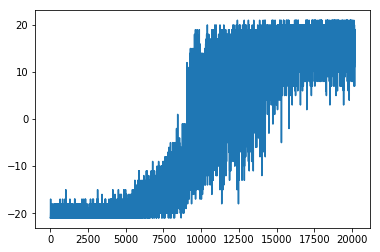

In [5]:
env.close()
torch.save(actor_critic, 'results/actor_critic.pkl')
plt.plot(scores_all_envs)

In [5]:
n_iter = 3

env = make_atari_env('PongNoFrameskip-v0', num_env=1, seed=24)
env = VecFrameStack(env, n_stack=num_frames)

n_actions = env.action_space.n

actor_critic = ActorCritic(n_actions).to(device)
testModel = torch.load('results/actor_critic.pkl')
actor_critic.load_state_dict(testModel.state_dict())

state = env.reset()
for _ in range(n_iter):
    for _ in count():
        env.render()
        state = torch.from_numpy(state.transpose((0, 3, 1, 2))).float() / 255.
        logit, values = actor_critic(state)
        
        probs = F.softmax(logit)
        actions = probs.multinomial(1).data
        
        state, rewards, dones, _ = env.step(actions.cpu().numpy())
        if dones:
            break
env.close()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
